## Healthcare Expenditure Analysis
___

This notebook explores the relationship between healthcare expenditure per capita vs life expectancy. 

Specifically, accounting for obesity rate by country to address misconceptions around the following chart:
<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d6/Life_expectancy_vs_healthcare_spending.jpg/350px-Life_expectancy_vs_healthcare_spending.jpg" width="400"/>
</div>

This chart is used by many to criticize the US healthcare system and push for a single payer system.

It shows that the US has a much lower life expectancy than other countries while spending much more on healthcare, about $12,500 per capita/per year.

___
### Recreation of the analysis

In [29]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from bs4 import BeautifulSoup
from sklearn.linear_model import LinearRegression

#### Countries with no NaNs ####
Countries = ['Australia', 'Austria', 'Belgium', 'Canada', 'Chile', 'Costa Rica', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 
             'Greece', 'Hungary', 'Ireland', 'Italy', 'Japan', 'Latvia', 'Lithuania', 'Luxembourg', 'Mexico', 'Netherlands', 'New Zealand', 
             'Norway', 'Poland', 'Portugal', 'Slovakia', 'Slovenia', 'South Korea', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom', 'United States']

##### Scrape data from Wikipedia
- [Healthcare Expenditures by Country](https://en.wikipedia.org/wiki/List_of_countries_by_total_health_expenditure_per_capita)
- [Life Expectancy by Country]('https://en.wikipedia.org/wiki/List_of_countries_by_life_expectancy)

In [ ]:
def get_expenditure_by_country():
    page = requests.get('https://en.wikipedia.org/wiki/List_of_countries_by_total_health_expenditure_per_capita').text
    soup = BeautifulSoup(page, 'html.parser')
    table = soup.find('table', class_="wikitable sortable static-row-numbers mw-datatable sticky-table-head sticky-table-col1 sort-under")
    expenditure_by_country = pd.read_html(str(table))
    expenditure_by_country = pd.concat(expenditure_by_country)

    expenditure_by_country = expenditure_by_country[['Location', '2022']]
    expenditure_by_country = expenditure_by_country.rename(columns = {'Location':'Country', '2022':'Expenditure'})

    expenditure_by_country.to_csv("expenditure_by_country.csv", index=False)
    expenditure_by_country = expenditure_by_country[expenditure_by_country['Country'].isin(Countries)]

    expenditure_by_country = expenditure_by_country.sort_values('Country')
    
    return expenditure_by_country

def get_life_expectancy_by_country():
    page = requests.get('https://en.wikipedia.org/wiki/List_of_countries_by_life_expectancy').text
    soup = BeautifulSoup(page, 'html.parser')
    table = soup.find('table', class_="wikitable sortable mw-datatable sort-under sticky-table-head sticky-table-col1 static-row-numbers")

    life_expectancy_by_country = pd.read_html(str(table))
    life_expectancy_by_country = pd.concat(life_expectancy_by_country)

    life_expectancy_by_country = life_expectancy_by_country.iloc[ : , 0:2].droplevel(0, axis = 1)
    life_expectancy_by_country = life_expectancy_by_country.rename(columns = {'Countries and territories':'Country', 'at birth':'Life_Expectancy'})
    life_expectancy_by_country['Country'].values[life_expectancy_by_country['Country'] == 'Czechia'] = 'Czech Republic'

    return life_expectancy_by_country

#### Data Imports ####
expenditure_by_country = get_expenditure_by_country()
life_expectancy_by_country = get_life_expectancy_by_country()

#### Combine Datasets ####
healthcare = expenditure_by_country.merge(life_expectancy_by_country, how = 'left', on = 'Country')

##### Chart life expenctancy vs health expenditure

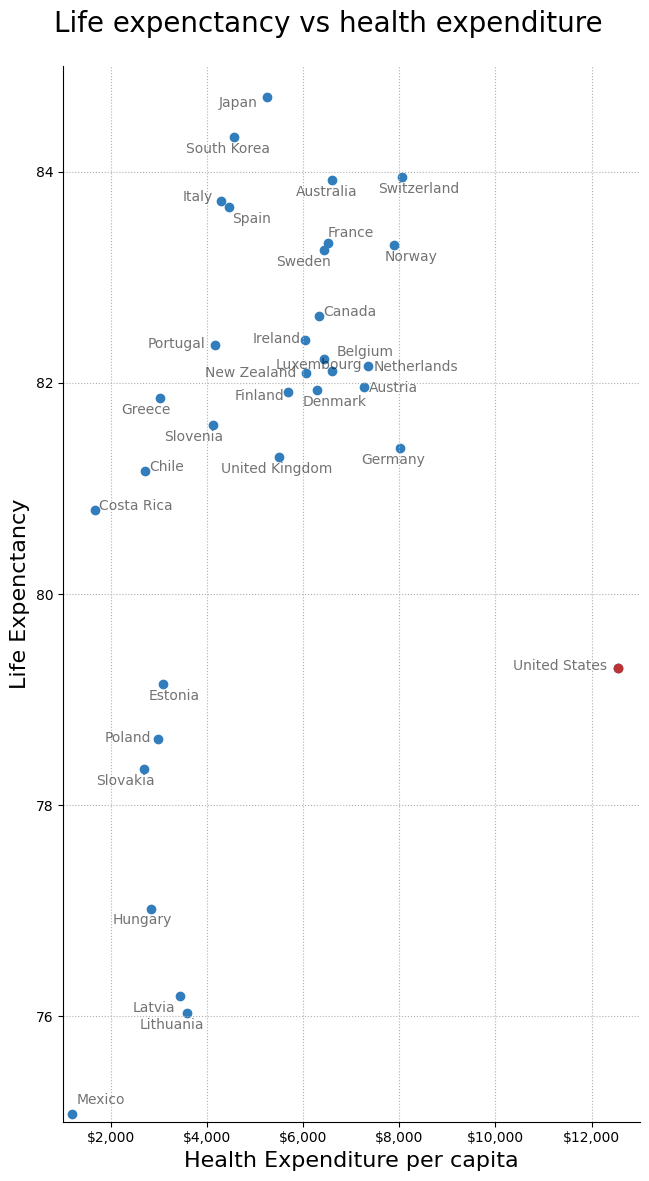

In [31]:
def chart_life_expectancy_vs_health_expenditure(healthcare):
    fig, ax = plt.subplots()
    fig.set_figheight(16 * 0.75)
    fig.set_figwidth(9 * 0.75)
    plt.xlabel('Health Expenditure per capita', fontsize = 16)
    plt.ylabel('Life Expenctancy', fontsize = 16)
    plt.suptitle('Life expenctancy vs health expenditure', fontsize = 20)
    plt.title(' ')
    plt.tight_layout()
    plt.grid(linestyle=':')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim([1000, 13000])
    ax.set_ylim([75, 85])
    ax.xaxis.set_major_formatter('${x:,.0f}')
    ax.scatter(healthcare['Expenditure'], healthcare['Life_Expectancy'], color = "#327ebd")
    ax.scatter(healthcare['Expenditure'].values[healthcare['Country'] == 'United States'], healthcare['Life_Expectancy'].values[healthcare['Country'] == 'United States'], color = '#bd3232')

    annotate_offsets = [
        (-750, -0.15), # Australia
        (100, -0.05), # Austria
        (100, 0.15), # Belgium
        (100, 0.00), # Canada
        (100, 0.00), # Chile
        (100, 0.00), # Costa Rica
        (-300, -0.15), # Denmark
        (-300, -0.15), # Estonia
        (-1100, -0.07), # Finland
        (0, 0.05), # France
        (-800, -0.15), # Germany
        (-800, -0.15), # Greece
        (-800, -0.15), # Hungary
        (-1100, -0.03), # Ireland
        (-800, 0.0), # Italy
        (-1000, -0.1), # Japan
        (-1000, -0.15), # Latvia
        (-1000, -0.15), # Lithuania
        (-1000, -0.1), # Luxembourg
        (100, 0.1), # Mexico
        (100, -0.05), # Netherlands
        (-2100, -0.03), # New Zealand
        (-200, -0.15), # Norway
        (-1100, -0.03), # Poland
        (-1400, -0.03), # Portugal
        (-1000, -0.15), # Slovakia
        (-1000, -0.15), # Slovenia
        (-1000, -0.15), # South Korea
        (50, -0.15), # Spain
        (-1000, -0.15), # Sweden
        (-500, -0.15), # Switzerland
        (-1200, -0.15), # United Kingdom
        (-2200, -0.02)  # United States
        ]

    for i, label in enumerate(healthcare['Country']):
        ax.annotate(label, (healthcare['Expenditure'].values[i] + annotate_offsets[i][0], healthcare['Life_Expectancy'].values[i] + annotate_offsets[i][1]), alpha = 0.55)

chart_life_expectancy_vs_health_expenditure(healthcare)

___
### Disposable income

The original chart doesn't account for relative wealth levels of each country.

1) Wealthier countries can spend a higher percent of income on healthcare
2) Wealthier countries naturally charge more for heath services

To account for this, convert healthcare expenditure to percent of disposable income.

##### Scrape data from Wikipedia
- [Disposable Income by Country](https://en.wikipedia.org/wiki/Disposable_household_and_per_capita_income)

In [ ]:
def get_disposable_income_by_country():
    page = requests.get('https://en.wikipedia.org/wiki/Disposable_household_and_per_capita_income').text
    soup = BeautifulSoup(page, 'html.parser')
    table = soup.find('table', class_="sortable wikitable static-row-numbers sticky-table-head")

    income = pd.read_html(str(table))
    income = pd.concat(income)

    income = income.rename(columns = {'Location':'Country', '2022* (USD PPP)[1]':'Disposable_Income'})
    income['Disposable_Income'] = income['Disposable_Income'].str.replace(' (2021)', '')
    income['Disposable_Income'] = income['Disposable_Income'].str.replace(' (2019)', '')
    income['Disposable_Income'] = income['Disposable_Income'].str.replace(',', '')
    income['Disposable_Income'] = pd.to_numeric(income['Disposable_Income'])

    return income

#### Combine Data ####
disposable_income_by_country = get_disposable_income_by_country()
healthcare = healthcare.merge(disposable_income_by_country, how = 'left', on = 'Country')

#### Calculate expenditure as percent of income ####
healthcare['Expenditure_As_Percent_of_Income'] = (healthcare['Expenditure']/healthcare['Disposable_Income'])*100

#### Add trendline ####
reg_expenditure_by_income = LinearRegression()
reg_expenditure_by_income.fit(healthcare[['Disposable_Income']], healthcare['Expenditure_As_Percent_of_Income'])
healthcare['Expenditure_As_Percent_of_Income_Trend'] = reg_expenditure_by_income.predict(healthcare[['Disposable_Income']])

#### Calculate Difference from Trendline ####
healthcare['Excess_Expenditure_as_Percent'] = healthcare['Expenditure_As_Percent_of_Income'] - healthcare['Expenditure_As_Percent_of_Income_Trend']

##### Chart Expenditure by Income

When healthcare expenditure is adjusted for by disposable income, US spending is much more in line with other countries.

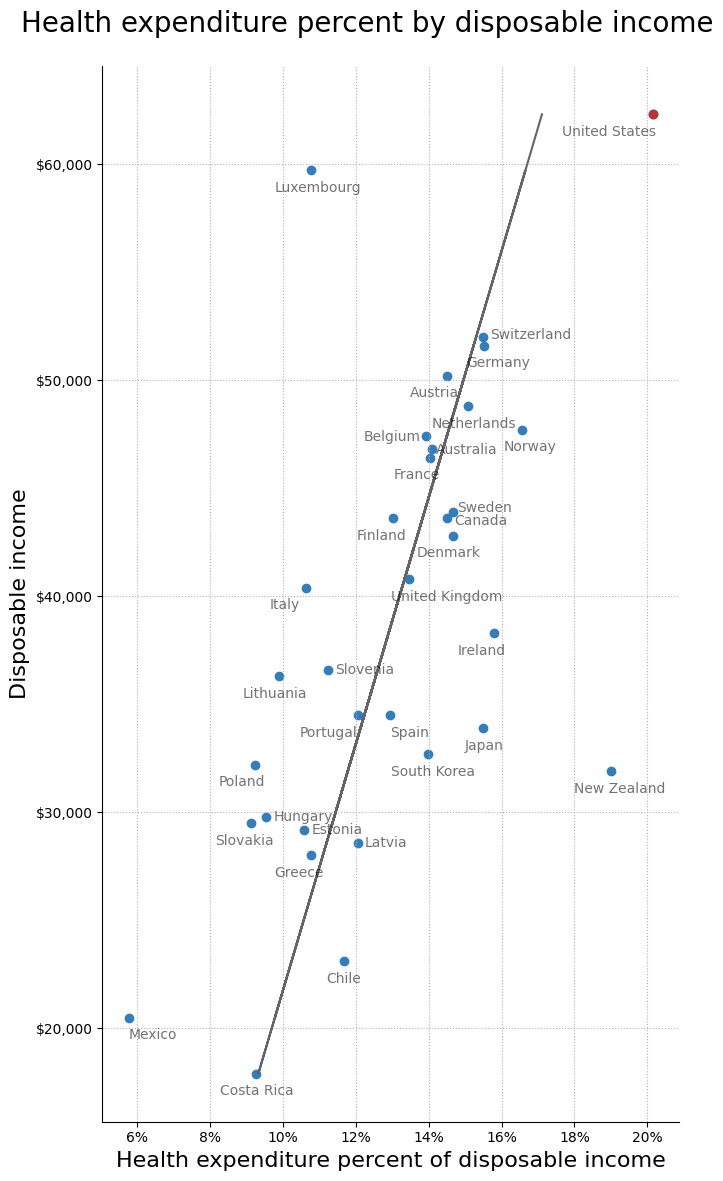

In [33]:
def chart_expenditure_by_income_trend(healthcare):
    fig, ax = plt.subplots()
    fig.set_figheight(16 * 0.75)
    fig.set_figwidth(9 * 0.75)
    plt.xlabel('Health expenditure percent of disposable income', fontsize = 16)
    plt.ylabel('Disposable income', fontsize = 16)
    plt.suptitle('Health expenditure percent by disposable income', fontsize = 20)
    plt.title(' ')
    plt.tight_layout()
    plt.grid(linestyle=':')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.set_xlim([1000, 13000])
    # ax.set_ylim([78, 84])
    ax.xaxis.set_major_formatter('{x:,.0f}%')
    ax.yaxis.set_major_formatter('${x:,.0f}')
    ax.scatter(healthcare['Expenditure_As_Percent_of_Income'], healthcare['Disposable_Income'], color = "#327ebd")
    ax.scatter(healthcare['Expenditure_As_Percent_of_Income'].values[healthcare['Country'] == 'United States'], healthcare['Disposable_Income'].values[healthcare['Country'] == 'United States'], color = '#bd3232')
    ax.plot(healthcare['Expenditure_As_Percent_of_Income_Trend'], healthcare['Disposable_Income'], color = '#646464')
    annotate_offsets = [
        (0.1, -200), # Australia
        (-1.0, -1000), # Austria
        (-1.7, -200), # Belgium
        (0.2, -300), # Canada
        (-0.5, -1000), # Chile
        (-1.0, -1000), # Costa Rica
        (-1.0, -1000), # Denmark
        (0.2, -200), # Estonia
        (-1.0, -1000), # Finland
        (-1.0, -1000), # France
        (-0.5, -1000), # Germany
        (-1.0, -1000), # Greece
        (0.2, -200), # Hungary
        (-1.0, -1000), # Ireland
        (-1.0, -1000), # Italy
        (-0.5, -1000), # Japan
        (0.2, -200), # Latvia
        (-1.0, -1000), # Lithuania
        (-1.0, -1000), # Luxembourg
        (0.0, -1000), # Mexico
        (-1.0, -1000), # Netherlands
        (-1.0, -1000), # New Zealand
        (-0.5, -1000), # Norway
        (-1.0, -1000), # Poland
        (-1.6, -1000), # Portugal
        (-1.0, -1000), # Slovakia
        (0.2, -200), # Slovenia
        (-1.0, -1000), # South Korea
        (0.0, -1000), # Spain
        (0.1, 0), # Sweden
        (0.2, -100), # Switzerland
        (-0.5, -1000), # United Kingdom
        (-2.5, -1000)  # United States
        ]

    for i, label in enumerate(healthcare['Country']):
        ax.annotate(label, (healthcare['Expenditure_As_Percent_of_Income'].values[i] + annotate_offsets[i][0], healthcare['Disposable_Income'].values[i] + annotate_offsets[i][1]), alpha = 0.55)

chart_expenditure_by_income_trend(healthcare)

##### Excess healthcare expenditure

To calculate the actual level of excess spending, compare the trendline to the actual expenditure percent.

This shows the US is high but by no means an outlier.

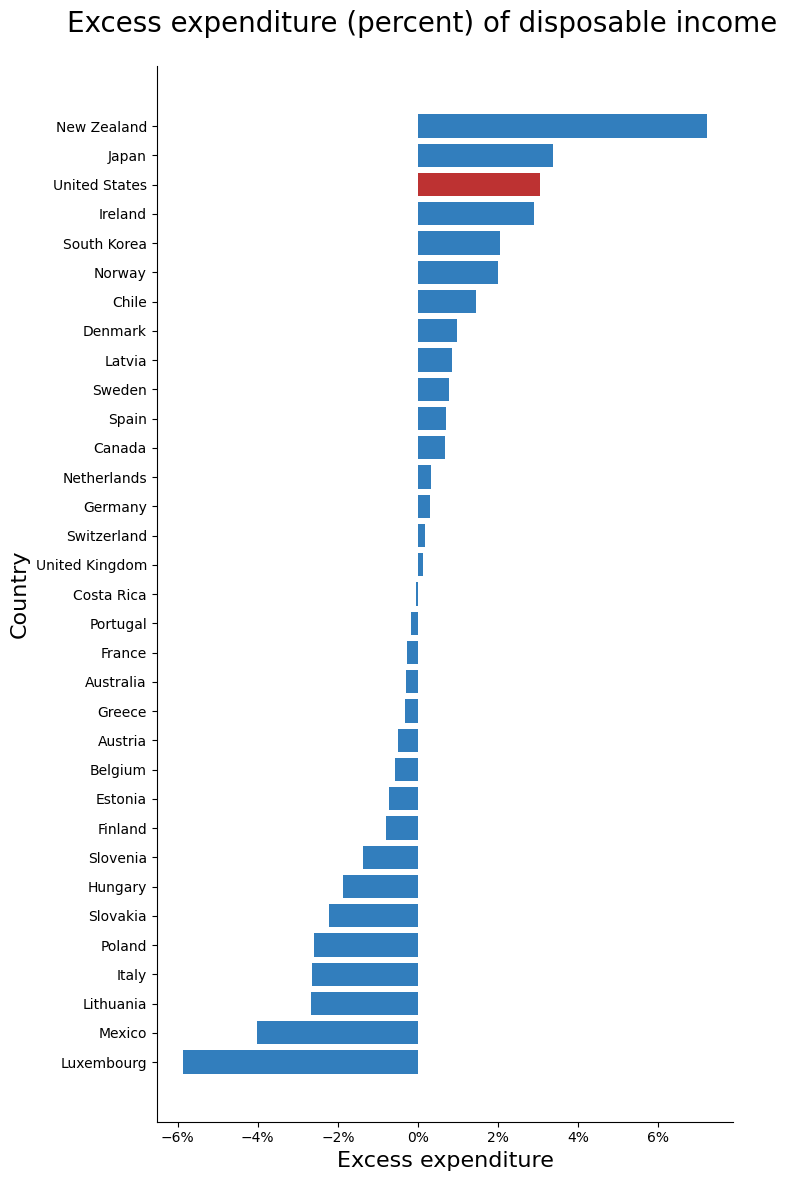

In [34]:
def chart_excess_expenditure(healthcare):
    healthcare = healthcare.sort_values('Excess_Expenditure_as_Percent')
    fig, ax = plt.subplots()
    fig.set_figheight(16 * 0.75)
    fig.set_figwidth(9 * 0.75)
    plt.xlabel('Excess expenditure', fontsize = 16)
    plt.ylabel('Country', fontsize = 16)
    plt.suptitle('Excess expenditure (percent) of disposable income', fontsize = 20)
    plt.title(' ')
    plt.tight_layout()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_major_formatter('{x:,.0f}%')
    ax.barh(healthcare['Country'], healthcare['Excess_Expenditure_as_Percent'], color = "#327ebd")
    ax.barh(healthcare['Country'].values[healthcare['Country'] == 'United States'], healthcare['Excess_Expenditure_as_Percent'].values[healthcare['Country'] == 'United States'], color = '#bd3232')

chart_excess_expenditure(healthcare)

___
### Obesity Rates

The original chart doesn't account for relative health of country populations.

1) The US has a very high obesity rate. This effects life expectancy.

To account for this, add obesity rates to the data.

##### Scrape obesity rates from Wikipedia
- [Obesity Rates by Country](https://en.wikipedia.org/wiki/List_of_countries_by_obesity_rate)

In [ ]:
def get_obesity_rate_by_country():
    page = requests.get('https://en.wikipedia.org/wiki/List_of_countries_by_obesity_rate').text
    soup = BeautifulSoup(page, 'html.parser')
    table = soup.find('table', class_="wikitable plainrowheaders sortable sticky-header sort-under")

    obesity = pd.read_html(str(table))
    obesity = pd.concat(obesity)

    obesity = obesity[['Country', 'Percentage of adults with obesity (BMI≥30)']]
    obesity = obesity.rename(columns = {'Percentage of adults with obesity (BMI≥30)':'Obesity_Rate'})
    obesity['Obesity_Rate'] = pd.to_numeric(obesity['Obesity_Rate'], errors='coerce')
    obesity = obesity.dropna()
    obesity['Obesity_Rate'] = obesity['Obesity_Rate']
    return obesity

#### Combine Data ####
obesity_rate_by_country = get_obesity_rate_by_country()
healthcare = healthcare.merge(obesity_rate_by_country, how = 'left', on = 'Country')

#### Draw Trendline ####
reg_life_expectancy_vs_obesity_rate = LinearRegression()
reg_life_expectancy_vs_obesity_rate.fit(healthcare[['Obesity_Rate']], healthcare['Life_Expectancy'])
healthcare['Life_Expectancy_Trend'] = reg_life_expectancy_vs_obesity_rate.predict(healthcare[['Obesity_Rate']])

#### Calculate years added by healthcare system ####
healthcare['Years_Added'] = healthcare['Life_Expectancy'] - healthcare['Life_Expectancy_Trend']

##### Chart Expenditure by Obesity Rate

Based on the trendline, US life expectancy should be around 78.2 years. In reality, US life expectancy is around 79.3 years. 

The US system actually adds 1.1 years.

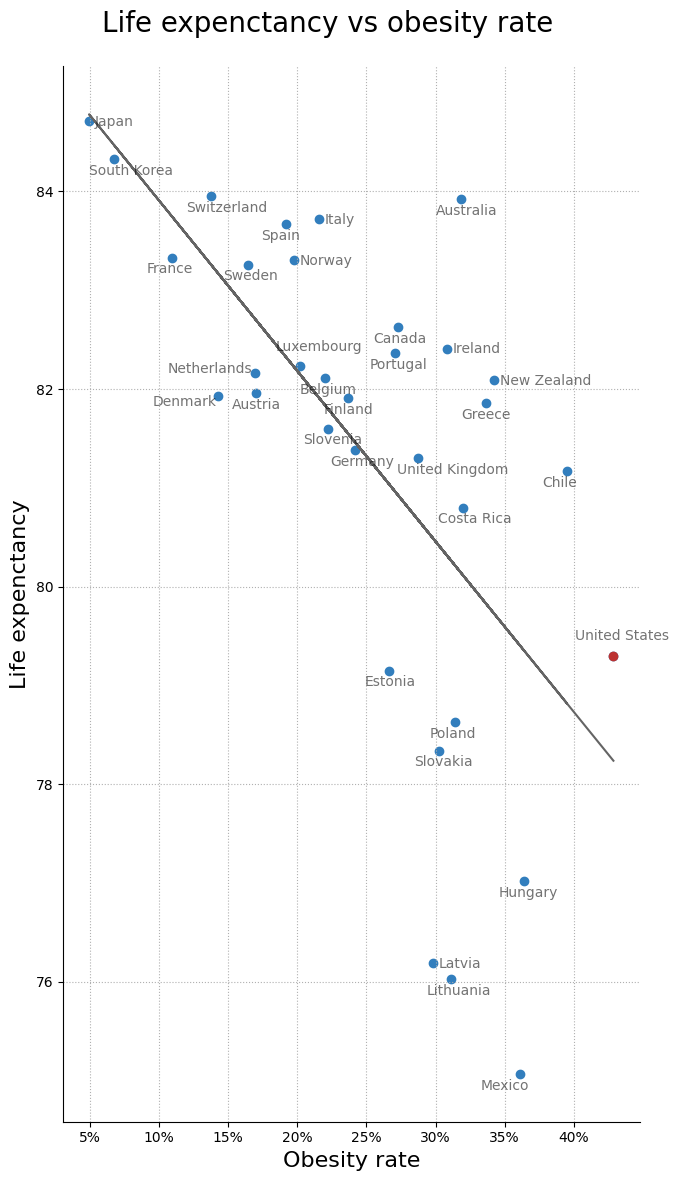

In [37]:
def chart_life_expectancy_vs_obesity_rate_trend(healthcare):
    fig, ax = plt.subplots()
    fig.set_figheight(16 * 0.75)
    fig.set_figwidth(9 * 0.75)
    plt.xlabel('Obesity rate', fontsize = 16)
    plt.ylabel('Life expenctancy', fontsize = 16)
    plt.suptitle('Life expenctancy vs obesity rate', fontsize = 20)
    plt.title(' ')
    plt.tight_layout()
    plt.grid(linestyle=':')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.set_xlim([1000, 13000])
    # ax.set_ylim([78, 84])
    ax.xaxis.set_major_formatter('{x:,.0f}%')
    ax.scatter(healthcare['Obesity_Rate'], healthcare['Life_Expectancy'], color = "#327ebd")
    ax.scatter(healthcare['Obesity_Rate'].values[healthcare['Country'] == 'United States'], healthcare['Life_Expectancy'].values[healthcare['Country'] == 'United States'], color = '#bd3232')
    ax.plot(healthcare['Obesity_Rate'], healthcare['Life_Expectancy_Trend'], color = '#646464')

    annotate_offsets = [
        (-1.8, -0.16), # Australia
        (-1.8, -0.16), # Austria
        (-1.8, -0.16), # Belgium
        (-1.8, -0.16), # Canada
        (-1.8, -0.16), # Chile
        (-1.8, -0.16), # Costa Rica
        (-4.8, -0.1), # Denmark
        (-1.8, -0.16), # Estonia
        (-1.8, -0.16), # Finland
        (-1.8, -0.16), # France
        (-1.8, -0.16), # Germany
        (-1.8, -0.16), # Greece
        (-1.8, -0.16), # Hungary
        (0.4, -0.05), # Ireland
        (0.4, -0.05), # Italy
        (0.4, -0.05), # Japan
        (0.4, -0.05), # Latvia
        (-1.8, -0.16), # Lithuania
        (-1.8, 0.16), # Luxembourg
        (-2.8, -0.16), # Mexico
        (-6.3, 0.0), # Netherlands
        (0.4, -0.05), # New Zealand
        (0.4, -0.05), # Norway
        (-1.8, -0.16), # Poland
        (-1.8, -0.16), # Portugal
        (-1.8, -0.16), # Slovakia
        (-1.8, -0.16), # Slovenia
        (-1.8, -0.16), # South Korea
        (-1.8, -0.16), # Spain
        (-1.8, -0.16), # Sweden
        (-1.8, -0.16), # Switzerland
        (-1.5, -0.16), # United Kingdom
        (-2.8, 0.16)  # United States
        ]

    for i, label in enumerate(healthcare['Country']):
        ax.annotate(label, (healthcare['Obesity_Rate'].values[i] + annotate_offsets[i][0], healthcare['Life_Expectancy'].values[i] + annotate_offsets[i][1]), alpha = 0.55)

chart_life_expectancy_vs_obesity_rate_trend(healthcare)

The US system by no means adds the most years, but is certainly reasonable compared to other countries.

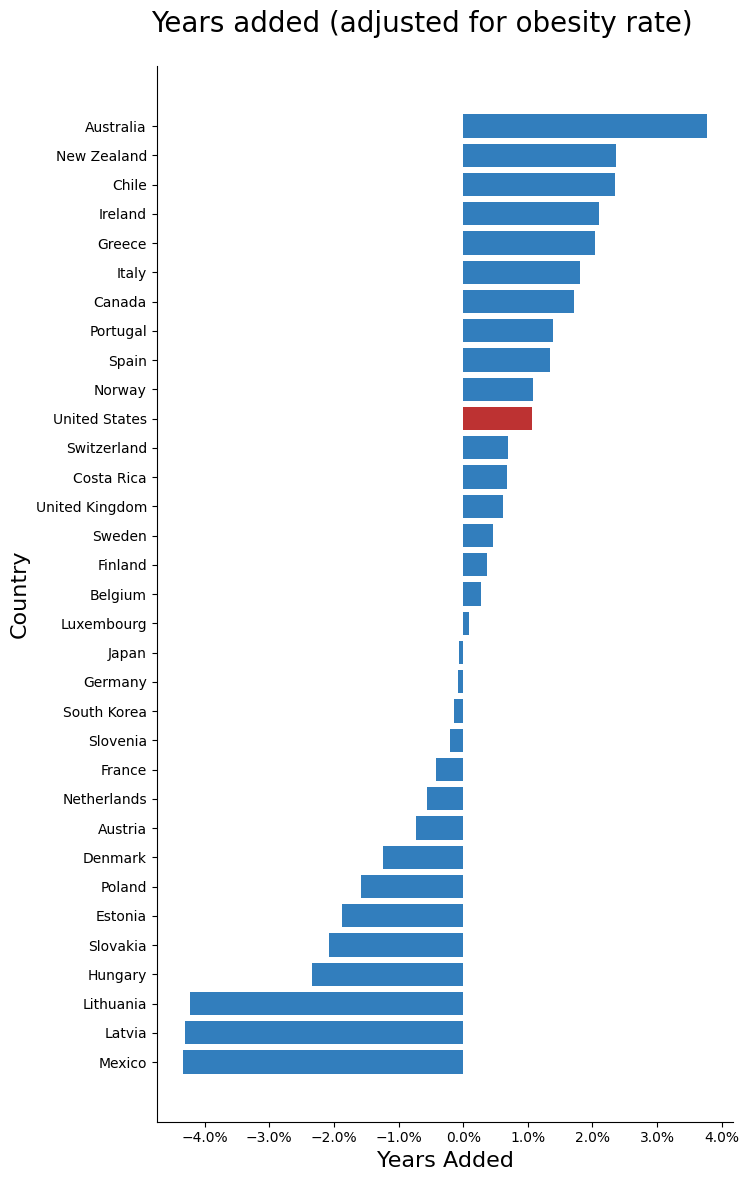

In [38]:
#### Calculate Years Added ####
def chart_years_added(healthcare):
    healthcare = healthcare.sort_values('Years_Added')
    fig, ax = plt.subplots()
    fig.set_figheight(16 * 0.75)
    fig.set_figwidth(9 * 0.75)
    plt.xlabel('Years Added', fontsize = 16)
    plt.ylabel('Country', fontsize = 16)
    plt.suptitle('Years added (adjusted for obesity rate)', fontsize = 20)
    plt.title(' ')
    plt.tight_layout()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_major_formatter('{x:,.1f}%')
    ax.barh(healthcare['Country'], healthcare['Years_Added'], color = "#327ebd")
    ax.barh(healthcare['Country'].values[healthcare['Country'] == 'United States'], healthcare['Years_Added'].values[healthcare['Country'] == 'United States'], color = '#bd3232')

chart_years_added(healthcare)

___
### Final Results

1) Calculate excess disposable income after healthcare expenditure.

When we compare years added by healthcare system to excess disposable income the US system looks pretty reasonable.

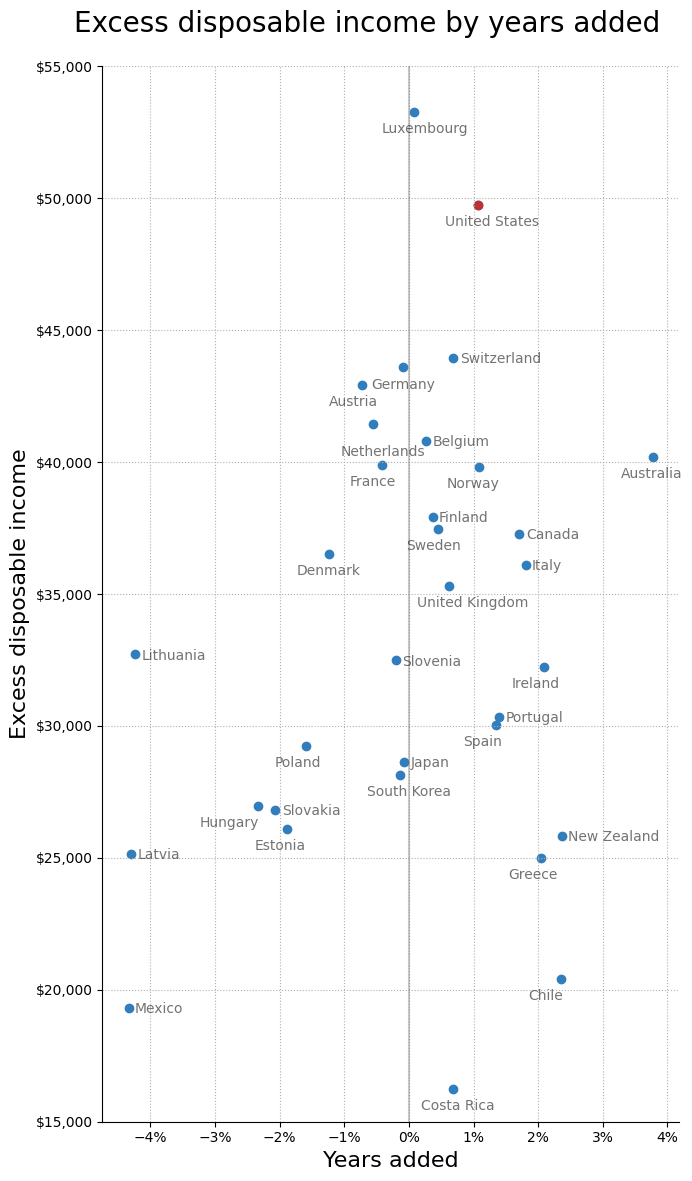

In [39]:
healthcare['Excess_Disposable_Income'] = healthcare['Disposable_Income'] - healthcare['Expenditure']

def chart_excess_disposable_income_by_years_added(healthcare):
    ##### Excess Disposable Income vs Years Added ####
    fig, ax = plt.subplots()
    fig.set_figheight(16 * 0.75)
    fig.set_figwidth(9 * 0.75)
    plt.xlabel('Years added', fontsize = 16)
    plt.ylabel('Excess disposable income', fontsize = 16)
    plt.suptitle('Excess disposable income by years added', fontsize = 20)
    plt.title(' ')
    plt.tight_layout()
    plt.grid(linestyle=':')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.set_xlim([15000, 55000])
    ax.set_ylim([15000, 55000])
    ax.xaxis.set_major_formatter('{x:,.0f}%')
    ax.yaxis.set_major_formatter('${x:,.0f}')
    ax.scatter(healthcare['Years_Added'], healthcare['Excess_Disposable_Income'], color = "#327ebd")
    ax.scatter(healthcare['Years_Added'].values[healthcare['Country'] == 'United States'], healthcare['Excess_Disposable_Income'].values[healthcare['Country'] == 'United States'], color = '#bd3232')
    ax.vlines(0, 15000, 55000, color = '#646464', alpha = 0.35)
              
    annotate_offsets = [
        (-0.5, -800), # Australia
        (-0.5, -800), # Austria
        (0.1, -200), # Belgium
        (0.1, -200), # Canada
        (-0.5, -800), # Chile
        (-0.5, -800), # Costa Rica
        (-0.5, -800), # Denmark
        (-0.5, -800), # Estonia
        (0.1, -200), # Finland
        (-0.5, -800), # France
        (-0.5, -800), # Germany
        (-0.5, -800), # Greece
        (-0.9, -800), # Hungary
        (-0.5, -800), # Ireland
        (0.1, -200), # Italy
        (0.1, -200), # Japan
        (0.1, -200), # Latvia
        (0.1, -200), # Lithuania
        (-0.5, -800), # Luxembourg
        (0.1, -200), # Mexico
        (-0.5, -1200), # Netherlands
        (0.1, -200), # New Zealand
        (-0.5, -800), # Norway
        (-0.5, -800), # Poland
        (0.1, -200), # Portugal
        (0.1, -200), # Slovakia
        (0.1, -200), # Slovenia
        (-0.5, -800), # South Korea
        (-0.5, -800), # Spain
        (-0.5, -800), # Sweden
        (0.1, -200), # Switzerland
        (-0.5, -800), # United Kingdom
        (-0.5, -800)  # United States
        ]

    for i, label in enumerate(healthcare['Country']):
        ax.annotate(label, (healthcare['Years_Added'].values[i] + annotate_offsets[i][0], healthcare['Excess_Disposable_Income'].values[i] + annotate_offsets[i][1]), alpha = 0.55)

chart_excess_disposable_income_by_years_added(healthcare)